In [1]:
import cv2
import tqdm
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from six.moves import urllib
from trdg.generators import (
    GeneratorFromDict,
    GeneratorFromRandom,
    GeneratorFromStrings,
    GeneratorFromWikipedia,
)

In [2]:
plt.ion() 

In [3]:
# get font
# !wget https://github.com/ulex/generate_license_plates/raw/master/RoadNumbers2.0.ttf
# !wget https://github.com/mingbocui/Generate-LicensePlate-with-GAN/raw/master/font/Lantinghei.ttc
# !wget https://github.com/mingbocui/Generate-LicensePlate-with-GAN/raw/master/font/platech.ttf
# !wget https://github.com/mingbocui/Generate-LicensePlate-with-GAN/raw/master/font/platechar.ttf

In [4]:
class ImgGenerator(torch.utils.data.Dataset):
    def __init__(self,
                  n: int = 1000,
                  img_w: int = 28,
                  img_h: int = 28,
                  batch_size: int = 32) -> None:
        self.img_h = img_h
        self.img_w = img_w
        self.n = n
        self.batch_size = batch_size
        self.dataset = []
        
        self.whitelist = [
            letter for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        ]
        self.generator = GeneratorFromStrings(
            self.whitelist,
            blur=2,
            skewing_angle=60,
            random_skew=True,
            random_blur=True,
            space_width=0,
            margins=(-12, -2, -2, -2),
        )
        for i, (img, lbl) in tqdm.tqdm(enumerate(self.generator)):
            img = np.array(img)
            img = cv2.resize(img, (img_w, img_h))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.normalize(img, None, alpha=0, beta=1,
                                norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            img = img.reshape((*img.shape, 1))
            img = np.moveaxis(np.array(img), 2, 0)
            y = np.zeros((len(self.whitelist)))
            y[self.whitelist.index(lbl)] = 1
            #print("item", y.shape)
            self.dataset.append([
                torch.from_numpy(img),
                torch.from_numpy(y)
            ])
            if i > n:
                break
    
    def __len__(self):
        """
        Denotes the total number of samples
        """
        return self.n
    
    def __getitem__(self, index):
        """
        Generates one sample of data
        """
        return self.dataset[index][0], self.dataset[index][1]

In [5]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    ImgGenerator(n = 32 * 3000, img_w = 28, img_h = 28, batch_size = 32), 
    batch_size=32, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    ImgGenerator(n = 32 * 300, img_w = 28, img_h = 28, batch_size = 32), 
    batch_size=32, shuffle=True, num_workers=4)

96001it [01:27, 1099.34it/s]
9601it [00:08, 1081.30it/s]


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 36)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        target = torch.max(target, 1)[1]
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#

In [9]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            target = torch.max(target, 1)[1]
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [10]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [11]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [12]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/96000 (0%)]	Loss: 3.587645
Train Epoch: 1 [16000/96000 (17%)]	Loss: 3.597148
Train Epoch: 1 [32000/96000 (33%)]	Loss: 3.564427
Train Epoch: 1 [48000/96000 (50%)]	Loss: 3.560485
Train Epoch: 1 [64000/96000 (67%)]	Loss: 3.327058
Train Epoch: 1 [80000/96000 (83%)]	Loss: 3.186777

Test set: Average loss: 2.3966, Accuracy: 3083/9600 (32%)

Train Epoch: 2 [0/96000 (0%)]	Loss: 2.880274
Train Epoch: 2 [16000/96000 (17%)]	Loss: 2.333189
Train Epoch: 2 [32000/96000 (33%)]	Loss: 2.237242
Train Epoch: 2 [48000/96000 (50%)]	Loss: 1.649508
Train Epoch: 2 [64000/96000 (67%)]	Loss: 1.598902
Train Epoch: 2 [80000/96000 (83%)]	Loss: 1.759853

Test set: Average loss: 0.9601, Accuracy: 7102/9600 (74%)

Train Epoch: 3 [0/96000 (0%)]	Loss: 1.357481
Train Epoch: 3 [16000/96000 (17%)]	Loss: 1.573073
Train Epoch: 3 [32000/96000 (33%)]	Loss: 1.087265
Train Epoch: 3 [48000/96000 (50%)]	Loss: 1.322997
Train Epoch: 3 [64000/96000 (67%)]	Loss: 1.065412
Train Epoch: 3 [80000/96000 (83%)]	Loss: 0.80

In [13]:
plt.rcParams["figure.figsize"] = (20,10)

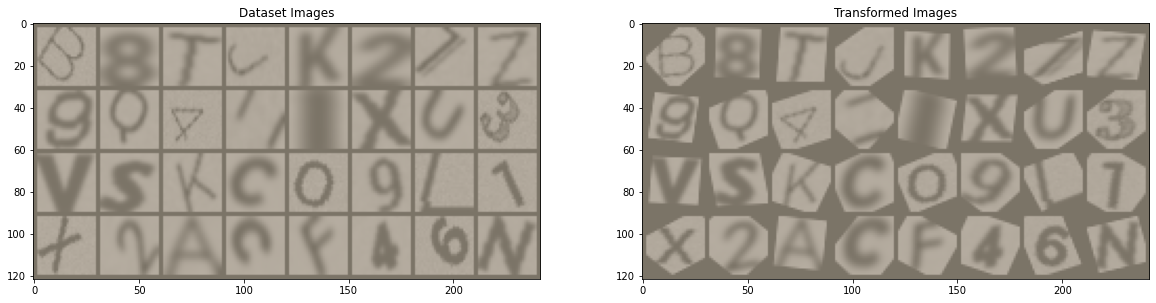

In [14]:
# Visualize the STN transformation on some input batch
visualize_stn()

In [15]:
plt.ioff()
plt.show()

In [16]:
torch.save(model.state_dict(), "letter_recognition.ph")